In [56]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [41]:
raw_train = pd.read_csv("./input/train.csv")
raw_test = pd.read_csv("./input/test.csv")

In [42]:
target = raw_train.target
whole = pd.concat([raw_train.drop("target", axis=1), raw_test], axis=0).reset_index(drop=True)

In [43]:
whole.first_active_month = whole.first_active_month.fillna("2017-09")
whole.first_active_month = pd.to_datetime(whole.first_active_month.apply(lambda x:str(x)+"-01"))
whole["elapsed_time"] = (datetime.datetime(2018, 2, 1) - whole.first_active_month).apply(lambda x:x.days)

In [44]:
whole.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92


In [8]:
h_trs = pd.read_csv("./input/historical_transactions.csv")
n_trs = pd.read_csv("./input/new_merchant_transactions.csv")

In [9]:
trs = pd.concat([h_trs, n_trs], axis=0).reset_index(drop=True)

In [10]:
trs.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


## RFM
---

recency
- 最後に利用した日（2018/05/01を基準日としている）

In [11]:
recency_df = trs.groupby("card_id")["purchase_date"].max().reset_index()
recency_df.purchase_date = pd.to_datetime(recency_df.purchase_date)
recency_df["recency"] = (datetime.datetime(2018, 5, 1, 0, 0, 0) - recency_df.purchase_date).apply(lambda x:x.days)

frequency
- 一ヶ月間での利用頻度

In [12]:
frequency_df = trs.card_id.value_counts().reset_index()
frequency_df.columns = ["card_id", "use_num"]
frequency_df = frequency_df.sort_values(by="card_id").reset_index(drop=True)
frequency_df["frequency"] = frequency_df.use_num / 3.0

monetary
- 平均購入金額

In [13]:
monetary_df = trs.groupby("card_id")["purchase_amount"].mean().reset_index()

## その他
---

In [14]:
authorized_df = trs[["card_id", "authorized_flag"]].copy()
authorized_df.authorized_flag = authorized_df.authorized_flag.replace({"Y":0, "N":1})
authorized_df = authorized_df.groupby("card_id")["authorized_flag"].sum().reset_index()

record = trs.card_id.value_counts().reset_index()
record.columns = ["card_id", "record_num"]

authorized_df = pd.merge(authorized_df, record, on="card_id", how="left")
authorized_df["authorized_N_percentage"] = authorized_df.authorized_flag / authorized_df.record_num

In [15]:
category_3_df = trs[["card_id", "category_3"]]
category_3_df.category_3 = category_3_df.dropna()

category_3_C_df.category_3 = category_3_C_df.category_3.apply(lambda x:1 if x == "C" else 0)
category_3_C_df = category_3_C_df.groupby("card_id")["category_3"].sum().reset_index()

In [16]:
rf_df = pd.merge(
    recency_df[["card_id", "recency"]], 
    frequency_df, 
    on="card_id", 
    how="left"
)

rfm_df = pd.merge(
    rf_df, 
    monetary_df, 
    on="card_id", 
    how="left"
)

transaction = pd.merge(rfm_df, authorized_df, on="card_id", how="left")
transaction = pd.merge(transaction, category_3_C_df, on="card_id", how="left")

transaction.to_csv("./input/transaction_20181201.csv.gz", index=False)

In [45]:
whole = pd.merge(
    whole, 
    transaction,
    on="card_id",
    how="left"
)

whole = whole.drop(["card_id", "first_active_month"], axis=1)


train = whole.iloc[:201917]
test = whole.iloc[201917:].reset_index(drop=True)

In [46]:
train.head()

,feature_1,feature_2,feature_3,elapsed_time,recency,use_num,frequency,purchase_amount,authorized_flag,record_num,authorized_N_percentage,category_3
0,5,2,1,245,1,283,94.333333,-0.633261,13,283,0.045936,0
1,4,1,0,396,31,356,118.666667,-0.602141,11,356,0.030899,72
2,2,2,0,549,2,44,14.666667,-0.678812,2,44,0.045455,0
3,4,3,0,153,12,84,28.000000,-0.644592,0,84,0.000000,7
4,1,3,0,92,2,169,56.333333,-0.405999,5,169,0.029586,8


In [47]:
# grid_params = {
#     "learning_rate": [0.05],
#     "n_estimators": [3000],
#     "max_depth": [5],
#     "min_child_weight": [1],
#     "gamma": [0.05],
#     "subsample": [0.8],
#     "colsample_bytree": [0.3],
#     "objective": ["reg:linear"],
#     "scale_pos_weight": [1],
#     "seed": [27]
# }

# gs = GridSearchCV(xgb.XGBRegressor(), grid_params, cv=3, n_jobs=2, scoring="neg_mean_squared_error")
# gs.fit(train[columns], target)

In [48]:
# gs.best_params_

In [49]:
reg = xgb.XGBRegressor(
        learning_rate =0.05,
        n_estimators=3000,
        max_depth=5,
        min_child_weight=1,
        gamma=0.05,
        subsample=0.8,
        colsample_bytree=0.3,
        objective= "reg:linear",
        scale_pos_weight=1,
        seed=27
    )

In [61]:
reg_lgb = lgb.LGBMRegressor(
    num_leaves= 50,
    min_data_in_leaf= 30, 
    objective="regression",
    max_depth= -1,
    learning_rate= 0.0041,
    boosting= "gbdt",
    feature_fraction= 0.9,
    bagging_freq= 1,
    bagging_fraction= 0.9,
    bagging_seed= 11,
    metric= "rmse",
    lambda_l1= 0.1,
    verbosity= -1
)

In [62]:
def cross_validation(model, tr, tg, cv=3):
    scores = []
    kfold = KFold(n_splits=cv, random_state=1, shuffle=True)
    for tr_idx, te_idx in kfold.split(tr.index):
        X_train, X_test = tr.iloc[tr_idx], tr.iloc[te_idx]
        Y_train, Y_test = tg.iloc[tr_idx], tg.iloc[te_idx]
        
        model.fit(X_train, Y_train)
        predict = model.predict(X_test)
        
        score = np.sqrt(mean_squared_error(predict, Y_test))
        scores.append(score)
    
    validation_score = np.mean(scores)
    return validation_score

In [63]:
cross_validation(reg_lgb, train, target, cv=3)

3.8140436337060373

In [51]:
cross_validation(reg, train, target, cv=3)  #現段階の最高は3.833ぐらい

3.8347255781563216

In [52]:
reg = xgb.XGBRegressor(
        learning_rate =0.05,
        n_estimators=3000,
        max_depth=5,
        min_child_weight=1,
        gamma=0.05,
        subsample=0.8,
        colsample_bytree=0.3,
        objective= "reg:linear",
        scale_pos_weight=1,
        seed=27
    )

In [53]:
reg = xgb.XGBRegressor(
        learning_rate =0.05,
        n_estimators=3000,
        max_depth=5,
        min_child_weight=1,
        gamma=0.05,
        subsample=0.8,
        colsample_bytree=0.3,
        objective= "reg:linear",
        scale_pos_weight=1,
        seed=27
    )

In [64]:
reg_lgb.fit(train, target)

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.9, importance_type='split',
       lambda_l1=0.1, learning_rate=0.0041, max_depth=-1, metric='rmse',
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=30,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=50,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [54]:
reg.fit(train, target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0.05, learning_rate=0.05,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=3000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)

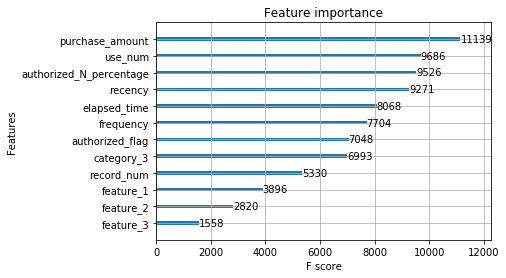

In [55]:
xgb.plot_importance(reg)

In [65]:
predict = reg_lgb.predict(test)

submission = pd.DataFrame({"card_id":raw_test.card_id, "target":predict})
submission.to_csv("./output/submission_20181201.csv", index=False)
# score: 3.866